# Lab:  Nonlinear Least Squares for Modeling Materials

Nonlinear least squares (NLLS) is a widely-used method for modeling data.  In NLLS, we wish to fit a model of the form,

     yhat = g(x,w)
     
where `w` is a vector of paramters and `x` is the vector of predictors.  We find `w` by minimizing a least-squares function

     f(w) = \sum_i (y_i - g(x_i,w))^2
     
where the summation is over training samples `(x_i,y_i)`.  This is similar to linear least-squares, but the function `g(x,w)` may not be linear in `w`.  In general, this optimization has no closed-form expression.  So numerical optimization must be used.  

In this lab, we will implement gradient descent on NLLS in a problem of physical modeling of materials.  Specifically, we will estimate parameters for expansion of copper as a function of temperature using a real dataset.  In doing this lab, you will learn to:
* Set up a nonlinear least squares as an unconstrained optimization function
* Compute initial parameter estimates for a simple rational model
* Compute the gradients of the least squares objective
* Implement gradient descent for minimizing the objective
* Implement momentum gradient descent
* Visualize the convergence of the algorithm

We first import some key packages.

In [375]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, LinearRegression

## Load the Data

The NIST agency has an excellent [nonlinear regression website](https://www.itl.nist.gov/div898/strd/nls/nls_main.shtml) that has several datasets for nonlinear regression problems.  In this lab, we will use the data from a NIST study involving the thermal expansion of copper. The response variable is the coefficient of thermal expansion, and the predictor variable is temperature in degrees kelvin.  

> Hahn, T., NIST (1979), Copper Thermal Expansion Study.  (unpublished}

You can download the data as follows.

In [376]:
url = 'https://itl.nist.gov/div898/strd/nls/data/LINKS/DATA/Hahn1.dat'
df = pd.read_csv(url, skiprows=60, sep=' ',skipinitialspace=True, names=['y0','x0','dummy'])
df.head()

,y0,x0,dummy
0,0.591,24.41,NaN
1,1.547,34.82,NaN
2,2.902,44.09,NaN
3,2.894,45.07,NaN
4,4.703,54.98,NaN


Extract the `x0` and `y0` into arrays.  Rescale, `x0` and `y0` to values between `0` and `1` by dividing `x0` and `y0` by the maximum value.  Store the scaled values in vectors `x` and `y`.  The rescaling will help with the conditioning of the fitting.  Plot, `y` vs. `x`.

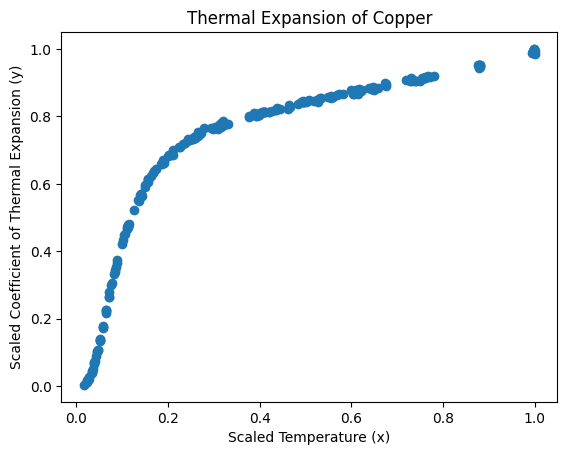

In [377]:
# TODO 1
# x0 = ...
# y0 = ...
# x = x0/np.max(x0)
# y = y0/np.max(y0)
# plt.plot(...)

x0 = df['x0'].values
y0 = df['y0'].values

# Rescale x0 and y0
x = x0 / np.max(x0)
y = y0 / np.max(y0)

plt.plot(x, y, 'o')
plt.xlabel('Scaled Temperature (x)')
plt.ylabel('Scaled Coefficient of Thermal Expansion (y)')
plt.title('Thermal Expansion of Copper')
plt.show()

To make the problem a little more challenging, we will add some noise.  Add random Gaussian noise with mean 0 and std. dev = 0.02 to `y`.  Store the noisy results in `yn`. You can use the `np.random.normal()` function to add Gaussian noise. Plot `yn` vs. `x`.

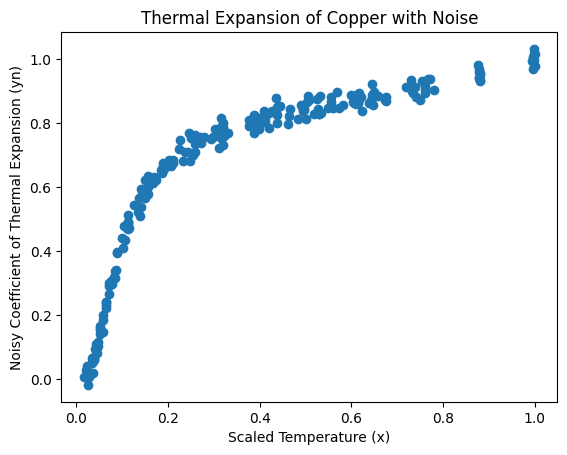

In [378]:
# TODO 2
# yn = y + ...
noise = np.random.normal(0, 0.02, y.shape)
yn = y + noise

plt.plot(x, yn, 'o')
plt.xlabel('Scaled Temperature (x)')
plt.ylabel('Noisy Coefficient of Thermal Expansion (yn)')
plt.title('Thermal Expansion of Copper with Noise')
plt.show()

Split the data `(x,yn)` into training and test.  Let `xtr,ytr` be training data and `xts,yts` be the test data.  You can use the `train_test_split` function.  Set `test_size=0.33` so that 1/3 of the samples are held out for test.

In [379]:
from sklearn.model_selection import train_test_split

# TODO 3
# xtr, xts, ytr, yts = ...
xtr, xts, ytr, yts = train_test_split(x, yn, test_size=0.33, random_state=42)

## Initial Fit for a Rational Model

The [NIST website](https://www.itl.nist.gov/div898/strd/nls/data/hahn1.shtml) suggests using a *rational* model of the form,

      yhat = (a[0] + a[1]*x + ... + a[d]*x^d)/(1 + b[0]*x + ... + b[d-1]*x^d)
      
with `d=3`.  The model parameters are `w = [a[0],...,a[d],b[0],...,b[d-1]]` so there are `2d+1` parameters total.    Complete the function below that takes vectors `w` and `x` and predicts a set of values `yhat` using the above model.
   

In [380]:
def predict(w,x):

    # Get the length
    d = (len(w)-1)//2

    # TODO 4.  Extract a and b from w
    # a = ...
    # b = ...
    a = w[:d+1]
    b = w[d+1:]

    a = np.flip(a)
    b = np.append([np.flip(b)],1)
    # TODO 5.  Compute yhat.  You may use the np.polyval function
    # But, remember you must flip the order the a and b
    # yhat = ...
    num = np.polyval(a, x)
    denominator = np.polyval(b, x)  # Append 1 for the constant term in the denominator

    # Compute yhat
    yhat = num / denominator
    return yhat

When we fit with a nonlinear model, most methods only get convergence to a local minima.  So, you need a good initial condition.  For a rational model, one way to get is to realize that if:


    y ~= (a[0] + a[1]*x + ... + a[d]*x^d)/(1 + b[0]*x + ... + b[d-1]*x^d)
    
Then:

    y ~= a[0] + a[1]*x + ... + a[d]*x^d - b[0]*x*y + ... - b[d-1]*x^d*y.
    
So, we can solve for the the parameters `w = [a,b]` from linear regression of the predictors,

    Z[i,:] = [ x[i], ... , x[i]**d, y[i]*x[i], ... , y[i}*x[i]**d ]

In [381]:
d = 3

# TODO 6.  Create the transformed feature matrix
# Z = ...
Z = np.column_stack([xtr**i for i in range(1,d+1)] + [ytr*xtr**i for i in range(1, d+1)])
# TODO 7.  Fit with parameters with linear regression
# regr = LinearRegression()
# regr.fit(...)
regr = LinearRegression()
regr.fit(Z, ytr)

# TODO 8
# Extract the parameters from regr.coef_ and regr.intercept_ and store the parameter vector in winit
# winit = ...
winit = np.concatenate(([regr.intercept_], regr.coef_[:d], regr.coef_[d:]))

winit

array([ -0.25849748,  11.20733062, -36.24413295,  27.66608196,
        -5.55668995,  28.55190024, -24.36723337])

Now plot the predicted values of the `yhat` vs. `x` using your estimated parameter `winit` for 1000 values `x` in `[0,1]`.  On the same plot, plot `yts` vs. `xts`.  You will see that you get a horrible fit.

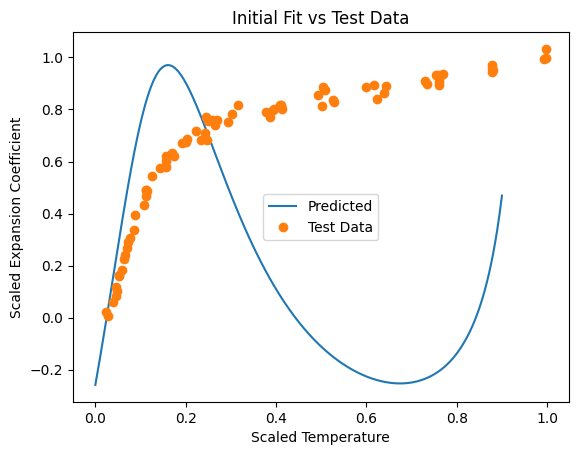

In [382]:
# TODO 9
# xp = ...
# yhat = ...
# plot(...)
xp = np.linspace(0, 0.9, 1000)
yhat = predict(winit, xp)

plt.plot(xp, yhat, label='Predicted')
plt.plot(xts, yts, 'o', label='Test Data')
plt.xlabel('Scaled Temperature')
plt.ylabel('Scaled Expansion Coefficient')
plt.title('Initial Fit vs Test Data')
plt.legend()
plt.show()

The reason the previous fit is poor is that the denominator in `yhat` goes close to zero.   To avoid this problem, we can use Ridge regression, to try to keep the parameters close to zero.  Re-run the fit above with `Ridge` with `alpha = 1e-3`. You should see you get a reasonable, but not perfect fit.

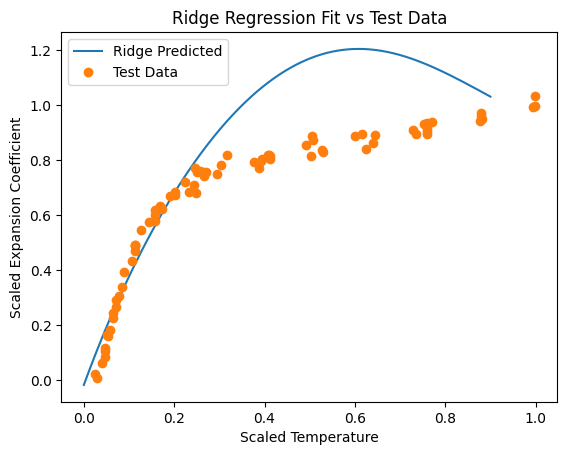

In [383]:
# TODO 10.  Fit with parameters with linear regression
# regr = Ridge(alpha=1e-3)
# regr.fit(...)
ridge_regr = Ridge(alpha=1e-3)
ridge_regr.fit(Z, ytr)

# TODO 11
# Extract the parameters from regr.coef_ and regr.intercept_
# winit = ...
winit = np.concatenate(([ridge_regr.intercept_], ridge_regr.coef_[:d], ridge_regr.coef_[d:]))


# TODO 12
# Plot the results as above.
yhat_ridge = predict(winit, xp)

plt.plot(xp, yhat_ridge, label='Ridge Predicted')
plt.plot(xts, yts, 'o', label='Test Data')
plt.xlabel('Scaled Temperature')
plt.ylabel('Scaled Expansion Coefficient')
plt.title('Ridge Regression Fit vs Test Data')
plt.legend()
plt.show()

## Creating a Loss Function

We can now use gradient descent to improve our initial estimate.  Complete the following function to compute

    f(w) = 0.5*\sum_i (y[i] - yhat[i])^2
    
and `fgrad`, the gradient of `f(w)`.

In [384]:
def feval(w, x, y):
    # TODO 13.  Parse w
    # a = ...
    # b = ...
    d = (len(w) - 1) // 2
    a = w[:d+1]
    b = w[d+1:]
    # TODO 14.  Znum[i,j] = x[i]**j
    Znum = np.array([x**j for j in range(d+1)]).T
    # TODO 15.  Zden[i,j] = x[i]**(j+1)
    Zden = 1 + np.dot(Znum[:, 1:], b)
    # TODO 16.  Compute yhat
    # Compute the numerator and denominator
    yhat = np.dot(Znum, a) / Zden
    # TODO 17.  Compute loss
    err = y - yhat
    f = 0.5 * np.sum(err**2)
    # TODO 18.  Compute gradients
    # fgrad = ...
    fgrad_a = -np.dot(Znum.T, err / Zden)
    fgrad_b = np.dot((Znum[:, 1:].T * yhat), err / Zden)
    fgrad = np.concatenate((fgrad_a, fgrad_b))

    return f, fgrad


Test the gradient function:
* Take `w0=winit` and compute `f0,fgrad0 = feval(w0,xtr,ytr)`
* Take `w1` very close to `w0` and compute `f1,fgrad1 = feval(w1,xtr,ytr)`
* Verify that `f1-f0` is close to the predicted value based on the gradient.

In [385]:
# TODO 19
w0 = winit
f0, fgrad0 = feval(w0, xtr, ytr)
eps = 1e-6
w1 = w0 + eps * np.random.normal(0, 1, w0.shape)
f1, fgrad1 = feval(w1, xtr, ytr)

print("f1 - f0:", f1 - f0)
print("Predicted:", np.dot(fgrad0, w1 - w0))


f1 - f0: -2.228941264403872e-05
Predicted: -2.2289466406430204e-05


## Implement gradient descent

We will now try to minimize the loss function with gradient descent.  Using the function `feval` defined above, implement gradient descent.  Run gradient descent with a step size of `alpha=1e-6` starting at `w=winit`.  Run it for `nit=10000` iterations.  Compute `fgd[it]`= the objective function on iteration `it`.  Plot `fgd[it]` vs. `it`.  

You should see that the training loss decreases, but it still hasn't converged after 10000 iterations.

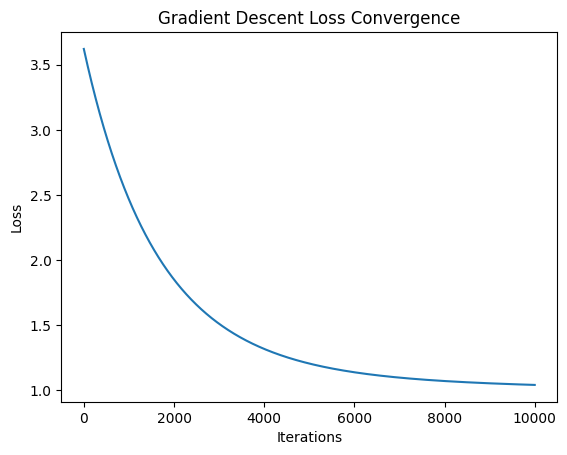

In [386]:
# TODO 20
# fgd = ...
w = winit
nit = 10000
step = 1e-6
fgd = np.zeros(nit)
for it in range(nit):
    f, fgrad = feval(w, xtr, ytr)
    fgd[it] = f
    w = w - step * fgrad

plt.plot(fgd)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Gradient Descent Loss Convergence')
plt.show()


Now, try to get a faster convergence with adaptive step-size using the Armijo rule. Implement the gradient descent with adaptive step size.  Let `fadapt[it]` be the loss function on iteration `it`.  Plot `fadapt[it]` and `fgd[it]` vs. `it` on the same graph.  You should see a slight improvement, but not much.

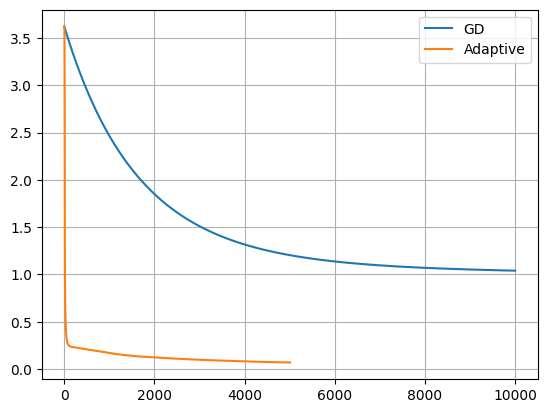

In [387]:
# TODO 21
# fadapt = ...
nit = 10000
step = 1e-6  # Initial step

w0 = winit
f0, fgrad0 = feval(w0, xtr, ytr)
fadapt = []
for i in range(nit):
    w1 = w0 - step*fgrad0
    f1, fgrad1 = feval(w1, xtr, ytr)
    df_est = fgrad0.dot(w1 - w0)
    alpha = 0.5
    if (f1-f0 < alpha*df_est) and (f1 < f0):
        step = step * 2
        f0 = f1
        fgrad0 = fgrad1
        w0 = w1
        fadapt.append(f0)
    else:
        step = step / 2

plt.plot(fgd, label="GD")
plt.plot(fadapt, label="Adaptive")
plt.legend()
plt.grid(True)

Using he final estimate for `w` from the adaptive step-size plot the predicted values of the `yhat` vs. `x` usfor 1000 values `x` in `[0,1]`.  On the same plot, plot `yhat` vs. `x` for the initial parameter `w=winit`.  Also, plot `yts` vs. `xts`.  You should see that gradient descent was able to improve the estimat slightly, although the initial estimate was not too bad.

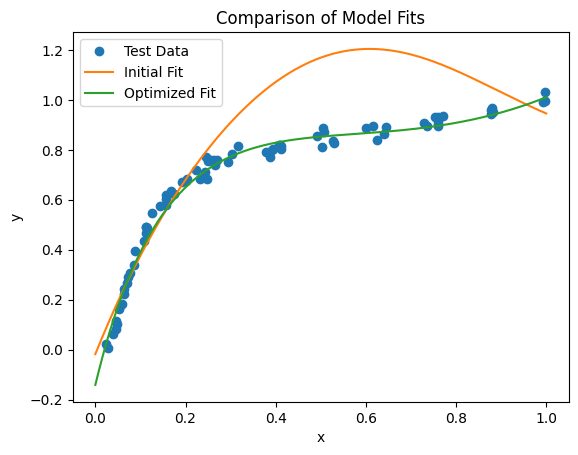

In [388]:
# TODO 22
# xp = np.linspace(...)
# yhat = ...
# plot(...)
xp = np.linspace(0, 1, 1000)
yhat_init = predict(winit, xp)
yhat_opt = predict(w0, xp)

plt.plot(xts, yts, 'o', label='Test Data')
plt.plot(xp, yhat_init, label='Initial Fit')
plt.plot(xp, yhat_opt, label='Optimized Fit')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Comparison of Model Fits')
plt.legend()
plt.show()


## Momentum Gradient Descent

This section is bonus.

One way to improve gradient descent is to use *momentum*.  In momentum gradient descent, the update rule is:

    f, fgrad = feval(w,...)
    z = beta*z + fgrad
    w = w - step*z
    
This is similar to gradient descent, except that there is a second order term on the gradient.  Implement this algorithm with `beta = 0.99` and `step=1e-3`.   Compare the convergence of the loss function with gradient descent.  

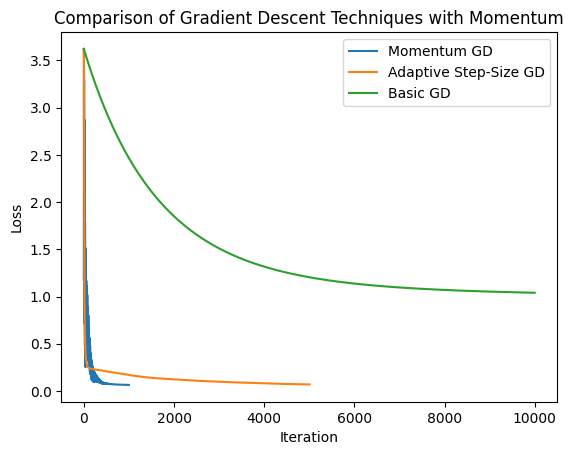

In [389]:
# TODO 23
nit = 1000
step = 1e-3
beta = 0.99
fmomentum = np.zeros(nit)
w = winit.copy()
z = np.zeros_like(w)

for it in range(nit):
    f, fgrad = feval(w, xtr, ytr)
    z = beta * z + fgrad
    w = w - step * z
    fmomentum[it] = f

plt.plot(fmomentum, label='Momentum GD')
plt.plot(fadapt, label='Adaptive Step-Size GD')
plt.plot(fgd, label='Basic GD')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Comparison of Gradient Descent Techniques with Momentum')
plt.legend()
plt.show()


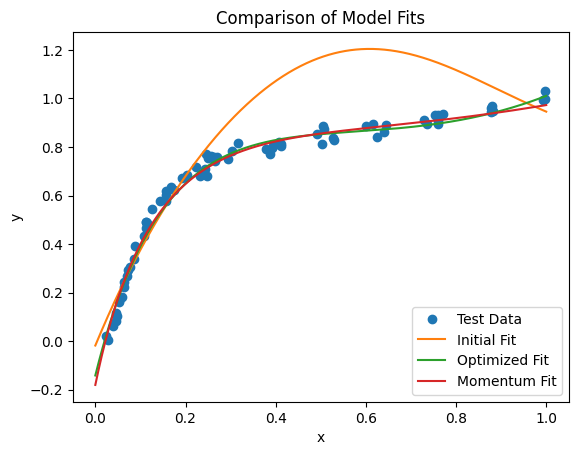

In [390]:
# TODO 24
# plot yhat vs. x
xp = np.linspace(0, 1, 1000)
yhat_momentum = predict(w, xp)

plt.plot(xts, yts, 'o', label='Test Data')
plt.plot(xp, yhat_init, label='Initial Fit')
plt.plot(xp, yhat_opt, label='Optimized Fit')
plt.plot(xp, yhat_momentum, label='Momentum Fit')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Comparison of Model Fits')
plt.legend()
plt.show()

## Beyond This Lab
In this lab, we have just touched at some of the ideas in optimization.  There are several other important algorithms that you can explore:
* [Levenberg-Marquardt](https://en.wikipedia.org/wiki/Levenberg%E2%80%93Marquardt_algorithm) method for non-linear least squares
* Newton's method
* More difficult non-linear least squares problems.